In [ ]:
!pip install gpytorch
!pip install botorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: linear-operator
    Found existing installation: linear-operator 0.5.0
    Uninstalling linear-operator-0.5.0:
      Successfully uninstalled linear-operator-0.5.0
  Attempting uninstall: gpytorch
    Found existing installation: gpytorch 1.11
    Uninstalling gpytorch-1.11:
      Successfully uninstalled gpytorch-1.11


In [ ]:
import os

import torch
from torch.quasirandom import SobolEngine

from botorch.optim import optimize_acqf
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.model import ModelList

from botorch.test_functions import Branin
from botorch.test_functions import Hartmann
from botorch.test_functions import Cosine8

In [ ]:
tkwargs = {
    "device": torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double,
}

In [ ]:
beta_mean_list = [1.0]
beta_constraint_list = [2.0, 2.5, 3.0]
penalty_list = [10]
#color_list = ['b', 'g', 'r', 'c', 'm', 'k']
#penalty_weight = 10
BO_iter = 50
num_restarts = 10
raw_samples = 1024
maxiter = 500
GP_iter = 200
learning_rate = 0.1
n_init = 10

In [ ]:
#objective info
dim_list= 6
name_list= "Hartmann"
objective_list = -3.32237
plot_bounds = [-4, 0]
negate_list = -1.0

In [ ]:
#Branin
hartmann = Hartmann(dim = 6, negate = True).to(**tkwargs)

def objective1(x):
  #lb, ub = branin.bounds
  #return branin(lb + (ub - lb) * x[..., :2])
  return hartmann(x)

In [ ]:
objective = [objective1]

In [ ]:
def compute_grad(x, objective):
  num_points, dimensions = x.shape
  epsilon = 0.01
  grad = torch.zeros(num_points, dimensions)
  for i in range(dimensions):
    x_upper = x.clone()
    x_upper[:, i] += epsilon
    x_lower = x.clone()
    x_lower[:, i] -= epsilon
    grad[:, i] = (objective(x_upper) - objective(x_lower)) / (2 * epsilon)
  return grad

In [ ]:
import gpytorch
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from botorch.models import ModelListGP
from botorch.models.higher_order_gp import FlattenedStandardize
from botorch.models.transforms import Normalize, Standardize
from botorch.models import HigherOrderGP, SingleTaskGP
from gpytorch.constraints import Interval
from botorch.optim.fit import fit_gpytorch_mll_torch
from botorch import fit_gpytorch_model

# train model function

def train_single_model(X, Y, nu=1.5, noiseless_obs=True):
  # make sure training data has the right dimension
  if Y.ndim == 1:
      Y = Y.unsqueeze(-1)
  # outcome transform
  standardize = Standardize(m=Y.shape[-1], batch_shape=Y.shape[:-2])
  outcome_transform = standardize
  # covariance module
  covar_module = ScaleKernel(MaternKernel(nu=nu, ard_num_dims=X.shape[-1]))
  # likelihood
  if noiseless_obs:
      _, aug_batch_shape = SingleTaskGP.get_batch_dimensions(
          train_X=X,
          train_Y=Y,
      )
      likelihood = GaussianLikelihood(
          batch_shape=aug_batch_shape,
          noise_constraint=Interval(lower_bound=1e-4, upper_bound=1e-3),
      )
  else:
      likelihood = None
  # define the model
  model = SingleTaskGP(
      train_X=X,
      train_Y=Y,
      covar_module=covar_module,
      likelihood=likelihood,
      outcome_transform=outcome_transform,
  )

  # call the training procedure
  model.outcome_transform.eval()
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  fit_gpytorch_model(mll)
  # put in eval mode
  model.eval()
  # return the model
  return model

def train_model(X, Y, nu=2.5, noiseless_obs=True):
  model_list = []
  noutput = Y.shape[1]
  for i in range(noutput):
    model_i = train_single_model(X, Y[:,i], nu=nu, noiseless_obs=noiseless_obs)
    model_list += [model_i]
  #model = ModelListGP(*model_list)
  return model_list

def get_posterior_stats(model, point):
  """Get the mean and standard deviation of the model's posterior at a given point."""
  #model_grad = self.model_all[1:]
  #model_grad[dim].eval()
  model.eval()
  #cur_points.requires_grad_ = True
  with torch.enable_grad():
    posterior = model.posterior(point)
    mean = posterior.mean
    std_dev = posterior.variance.sqrt()
  return mean, std_dev

In [ ]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.utils import t_batch_mode_transform
from torch import Tensor

class ConstrainedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: ModelList,
        beta_mean: float,
        beta_constraint: float,
        penalty_weight: int,
    ) -> None:
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.model_list_new = model_list_new
        self.beta_mean = beta_mean
        self.beta_constraint = beta_constraint
        self.penalty_weight = penalty_weight
        #self.register_buffer("beta", torch.as_tensor(beta))
        #self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform(expected_q=1)
    def forward(self, x: Tensor) -> Tensor:
        means, std_devs = get_posterior_stats(self.model_list_new, x) #b x q x d (q=1)
        means = means.squeeze() #b x d (removes q)
        std_devs = std_devs.squeeze() #b x d
        UCB = means[:, 0] + self.beta_mean * std_devs[:, 0] # b
        constraint_violation = torch.abs(means[:, 1:]) - self.beta_constraint * std_devs[:, 1:] #b x (d - 1) -> first dimension mean removed
        constraint_violation = constraint_violation.unsqueeze(-1) #b x (d-1) x 1
        zero = torch.zeros(constraint_violation.shape) #b x (d-1) x 1
        constraint_penalty = torch.sum(torch.max(constraint_violation, zero) ** 2, dim = 1).squeeze(-1) #b
        result = UCB - self.penalty_weight * constraint_penalty # b
        return result

In [ ]:
#create 3D torch tensor to store Y values (#trials to avg x #test problems x #BO methods x #BO iterations)
num_avg_trials = 1
num_penalty = len(penalty_list)
num_beta_mean = len(beta_mean_list)
num_beta_constraint = len(beta_constraint_list)

Y_all = torch.zeros((num_avg_trials, num_penalty, num_beta_mean, num_beta_constraint, n_init + BO_iter))

In [ ]:
def optimize_AF(acq_func, bounds, q = 1, num_restarts = num_restarts, raw_samples = raw_samples, maxiter = maxiter):
  candidate, acq_value = optimize_acqf(
            acq_function = acq_func,
            bounds = bounds,
            #torch.cat((torch.zeros(1, dim), torch.ones(1, dim))).to(**tkwargs),
            #batch_limit = 1,
            q = q,  # number of candidates to generate (1 for single-point optimization)
            num_restarts = num_restarts,  # number of starting points for multistart optimization
            raw_samples = raw_samples,  # number of samples for initialization heuristic
            options = {"maxiter": maxiter},
            sequential = True,  # use sequential optimization
  )
  return candidate, acq_value

In [ ]:
#perform trials separately due to errors

In [ ]:
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition import ExpectedImprovement
import matplotlib.pyplot as plt
import numpy as np
import botorch.settings
suppress_botorch_warnings = True

for a in range(num_avg_trials):
  for i, p in enumerate(penalty_list):
    for j, beta_mean in enumerate(beta_mean_list):
      for k, beta_constraint in enumerate(beta_constraint_list):
        bounds = torch.cat((torch.zeros(1, dim_list), torch.ones(1, dim_list))).to(**tkwargs)

        X = SobolEngine(dimension=dim_list, scramble=True, seed=0).draw(n_init).to(**tkwargs)
        Y = objective[0](X).unsqueeze(-1)
        Y_grad = compute_grad(X, objective[0])
        X_KKT = X
        Y_KKT = torch.hstack((Y, Y_grad))

        for l in range(BO_iter):
          #print general info
          print(f"\n Trial: {a + 1}, Iteration: {l + 1 + n_init}, Penalty: {p}, Beta mean: {beta_mean}, Beta constraint: {beta_constraint}")

          #KKT
          model_list = train_model(X_KKT, Y_KKT, nu = 2.5)
          model_list_new = ModelList(*model_list)
          acq_func = ConstrainedUCB(model_list_new, beta_mean, beta_constraint, p)
          candidate, acq_value = optimize_AF(acq_func, bounds)

          Y_mean_new = objective[0](candidate)
          Y_grad_new = compute_grad(candidate, objective[0]).squeeze()
          Y_new = torch.hstack((Y_mean_new, Y_grad_new))
          X_KKT = torch.vstack((X_KKT, candidate))
          Y_KKT = torch.vstack((Y_KKT, Y_new))
          Y_grad_GP = get_posterior_stats(model_list_new, candidate)[0][0, 1:]
          print("Best value: ", negate_list * Y_KKT[:, 0].max().item(), ", X: ", candidate, "AF: ", acq_value, ", Y: ", negate_list * Y_mean_new.item(), ", Y grad GP: ", negate_list * Y_grad_GP, ", Y grad query: ", negate_list * Y_grad_new)

          if len(Y_KKT) == n_init + BO_iter:
            Y_all[a, i, j, k] = Y_KKT[:, 0].reshape(n_init + BO_iter)


 Trial: 1, Iteration: 11, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.0
Best value:  -1.16420343697261 , X:  tensor([[0.9445, 0.9691, 0.9956, 0.1160, 0.8793, 0.8538]], dtype=torch.float64) AF:  tensor(1.3604, dtype=torch.float64) , Y:  -0.0002604075303723283 , Y grad GP:  tensor([ 0.6153, -0.0962, -0.0789, -1.2053,  0.0079,  1.1868],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.0003,  0.0025,  0.0013, -0.0002,  0.0036, -0.0006])

 Trial: 1, Iteration: 12, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.0
Best value:  -1.16420343697261 , X:  tensor([[0.8305, 0.0336, 0.9731, 0.5616, 0.6243, 0.1327]], dtype=torch.float64) AF:  tensor(1.2297, dtype=torch.float64) , Y:  -0.004870071807769201 , Y grad GP:  tensor([-0.1551, -0.4026, -0.1126, -1.6622, -0.1794, -0.0715],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.0219, -0.0088,  0.0097,  0.0243,  0.0484, -0.0371])

 Trial: 1, Iteration: 13, Penalty: 10, Beta mean: 1.0,

/usr/local/lib/python3.10/dist-packages/botorch/fit.py:171: RuntimeWarning: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.
  warn(str(err), RuntimeWarning)


Best value:  -3.190577241261887 , X:  tensor([[0.4233, 0.9962, 0.2256, 0.0909, 0.3446, 0.0000]], dtype=torch.float64) AF:  tensor(0.7044, dtype=torch.float64) , Y:  -0.2689172797326602 , Y grad GP:  tensor([ 0.4684,  0.2570, -0.0935, -2.3774,  0.0747, -0.3659],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.1737,  0.5051, -0.0228, -2.5752,  0.0173, -0.3276])

 Trial: 1, Iteration: 49, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.0
Best value:  -3.190577241261887 , X:  tensor([[0.2828, 0.6729, 0.1815, 0.9710, 0.0597, 0.0000]], dtype=torch.float64) AF:  tensor(0.7675, dtype=torch.float64) , Y:  -0.3464371283310722 , Y grad GP:  tensor([-1.7695, -2.1096, -0.1899,  2.4381, -0.0421, -1.1219],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.4333, -1.1620, -0.0244,  2.7495, -0.0044, -0.3703])

 Trial: 1, Iteration: 50, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.0
Best value:  -3.190577241261887 , X:  tensor([[1.0000, 0.2

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Best value:  -1.16420343697261 , X:  tensor([[1.0000, 0.1923, 0.2742, 0.0892, 0.3038, 0.3604]], dtype=torch.float64) AF:  tensor(0.6376, dtype=torch.float64) , Y:  -0.1629250565662835 , Y grad GP:  tensor([ 1.5606, -0.0351, -0.1340, -2.1077,  0.3191, -0.4637],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.7488,  0.0538, -0.0438, -0.6481, -0.0051, -0.7937])

 Trial: 1, Iteration: 14, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.5
Best value:  -1.16420343697261 , X:  tensor([[0.3532, 0.5504, 0.2643, 0.7529, 0.2259, 0.1425]], dtype=torch.float64) AF:  tensor(1.2462, dtype=torch.float64) , Y:  -0.7931831635672804 , Y grad GP:  tensor([ 0.4040,  0.5369, -0.0521,  1.2142,  0.1570, -0.9255],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.3310, -4.0536, -0.0674,  2.9409, -0.0350,  2.0898])

 Trial: 1, Iteration: 15, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.5
Best value:  -1.16420343697261 , X:  tensor([[0.0012, 0.9322

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Best value:  -1.7687779092311684 , X:  tensor([[0.4435, 0.7510, 0.8044, 0.4867, 1.0000, 0.2380]], dtype=torch.float64) AF:  tensor(1.2875, dtype=torch.float64) , Y:  -1.3346000729116847 , Y grad GP:  tensor([ 0.2397, -2.0827,  0.0618, -1.4069, -0.0856,  2.0446],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 1.7968, -2.7682,  0.0566, -2.2964,  0.2415,  7.3761])

 Trial: 1, Iteration: 23, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.5
Best value:  -2.6728381852574383 , X:  tensor([[0.4079, 0.7732, 0.7539, 0.5538, 1.0000, 0.0435]], dtype=torch.float64) AF:  tensor(1.6616, dtype=torch.float64) , Y:  -2.6728381852574383 , Y grad GP:  tensor([ 0.4094, -1.4655, -0.1437, -0.9471,  0.2105,  2.2464],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.3061, -4.6695, -0.0148, -1.0860,  0.4774,  0.3800])

 Trial: 1, Iteration: 24, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.5
Best value:  -2.6728381852574383 , X:  tensor([[0.3034, 

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Best value:  -2.9551022007874628 , X:  tensor([[0.5943, 1.0000, 1.0000, 0.4509, 0.4057, 0.3759]], dtype=torch.float64) AF:  tensor(0.7235, dtype=torch.float64) , Y:  -0.2936526632209691 , Y grad GP:  tensor([ 3.1037,  1.1085,  0.0327, -1.6767,  0.1564,  3.3252],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 1.7813,  0.6562,  0.0620, -0.5769,  0.1036,  2.4149])

 Trial: 1, Iteration: 52, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.5
Best value:  -2.9551022007874628 , X:  tensor([[0.0000, 0.0000, 0.8456, 0.7796, 0.3295, 0.5607]], dtype=torch.float64) AF:  tensor(0.6349, dtype=torch.float64) , Y:  -0.15176389736109858 , Y grad GP:  tensor([-0.2707, -0.1583,  0.1846,  0.8337,  0.3446, -0.7925],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.2196, -0.2228,  0.3699,  1.3306,  0.1149, -0.3345])

 Trial: 1, Iteration: 53, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.5
Best value:  -2.9551022007874628 , X:  tensor([[0.0793,

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Best value:  -2.9551022007874628 , X:  tensor([[0.4200, 0.6886, 0.7727, 1.0000, 0.3830, 0.0000]], dtype=torch.float64) AF:  tensor(0.8050, dtype=torch.float64) , Y:  -0.3744136636759145 , Y grad GP:  tensor([ 8.2475e-01, -2.1078e+00, -2.4154e-03,  2.4295e+00,  9.0703e-02,
        -1.0486e+00], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 1.9529e-01, -1.1610e+00, -2.6482e-03,  3.1889e+00,  2.0617e-02,
        -4.0109e-01])

 Trial: 1, Iteration: 56, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.5
Best value:  -2.9551022007874628 , X:  tensor([[0.6293, 0.5457, 0.2220, 0.7420, 0.1991, 0.1695]], dtype=torch.float64) AF:  tensor(0.6830, dtype=torch.float64) , Y:  -0.33272887623085795 , Y grad GP:  tensor([ 3.6104, -2.3101, -0.0177,  2.2644, -0.1478,  1.6080],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 2.4581, -1.6663, -0.0293,  1.2037, -0.0500,  1.0417])

 Trial: 1, Iteration: 57, Penalty: 10, Beta mean: 1.0, Beta constraint: 2.

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Best value:  -3.1934105118549 , X:  tensor([[0.3838, 0.8753, 0.7582, 0.4797, 0.0945, 0.0328]], dtype=torch.float64) AF:  tensor(3.0742, dtype=torch.float64) , Y:  -2.9053211595136594 , Y grad GP:  tensor([-1.7122, -0.3765, -0.0177, -2.5562, -0.0171, -0.9760],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-2.0479, -0.3196, -0.0209, -5.4621, -0.0421, -0.4814])

 Trial: 1, Iteration: 27, Penalty: 10, Beta mean: 1.0, Beta constraint: 3.0
Best value:  -3.1934105118549 , X:  tensor([[0.4057, 0.8758, 0.6305, 0.5673, 0.1878, 0.0776]], dtype=torch.float64) AF:  tensor(3.1862, dtype=torch.float64) , Y:  -3.1275458287434663 , Y grad GP:  tensor([ 0.1202, -0.2190, -0.0465, -0.4102,  0.0153,  0.1795],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.1288, -0.2983, -0.0625, -0.3809,  0.0107,  3.3437])

 Trial: 1, Iteration: 28, Penalty: 10, Beta mean: 1.0, Beta constraint: 3.0
Best value:  -3.1934105118549 , X:  tensor([[0.4028, 0.8130, 1

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Best value:  -3.1934105118549 , X:  tensor([[0.4063, 0.8908, 0.3603, 0.5888, 0.1738, 0.2546]], dtype=torch.float64) AF:  tensor(1.9811, dtype=torch.float64) , Y:  -1.667849241200376 , Y grad GP:  tensor([ 0.1507,  0.8028, -0.0304,  0.7612, -0.0527,  3.3705],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.1385,  0.3844, -0.1041,  0.6713, -0.1231,  9.6753])

 Trial: 1, Iteration: 34, Penalty: 10, Beta mean: 1.0, Beta constraint: 3.0
Best value:  -3.1934105118549 , X:  tensor([[0.3025, 0.5587, 0.7966, 0.6045, 0.0000, 0.0000]], dtype=torch.float64) AF:  tensor(1.6713, dtype=torch.float64) , Y:  -1.1248173351707857 , Y grad GP:  tensor([-2.1689, -2.9262, -0.0313,  1.3714, -0.2107, -1.7816],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-3.8843e+00, -5.8026e+00,  3.5825e-03,  6.9638e-01, -5.3923e-02,
        -1.2314e+00])

 Trial: 1, Iteration: 35, Penalty: 10, Beta mean: 1.0, Beta constraint: 3.0
Best value:  -3.1934105118549 ,

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Best value:  -3.1934105118549 , X:  tensor([[0.2996, 0.4345, 1.0000, 0.3337, 0.1537, 0.0000]], dtype=torch.float64) AF:  tensor(0.7623, dtype=torch.float64) , Y:  -0.3130583664455722 , Y grad GP:  tensor([-1.5195, -2.9814,  0.0340, -3.6029,  0.0315, -0.7227],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.0311, -2.0491,  0.0564, -1.3825, -0.1057, -0.5378])

 Trial: 1, Iteration: 55, Penalty: 10, Beta mean: 1.0, Beta constraint: 3.0


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Best value:  -3.1934105118549 , X:  tensor([[0.9073, 0.2858, 0.3650, 0.3069, 0.0195, 0.7088]], dtype=torch.float64) AF:  tensor(0.7401, dtype=torch.float64) , Y:  -0.18499224044554904 , Y grad GP:  tensor([ 1.4431,  0.2115, -0.0255, -0.9160, -0.4689, -0.2915],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.7207,  0.1563, -0.1095,  0.0662, -1.7304,  0.0657])

 Trial: 1, Iteration: 56, Penalty: 10, Beta mean: 1.0, Beta constraint: 3.0
Best value:  -3.1934105118549 , X:  tensor([[0.1202, 1.0000, 0.8631, 0.7991, 1.0000, 0.0000]], dtype=torch.float64) AF:  tensor(0.7828, dtype=torch.float64) , Y:  -0.39584245026783155 , Y grad GP:  tensor([-4.6312,  1.5919, -0.0698,  2.7101, -0.1360, -0.5786],
       dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-3.8262e+00,  7.4228e-01,  1.4211e-03,  1.7785e+00,  7.0603e-02,
        -4.2316e-01])

 Trial: 1, Iteration: 57, Penalty: 10, Beta mean: 1.0, Beta constraint: 3.0
Best value:  -3.193410511854

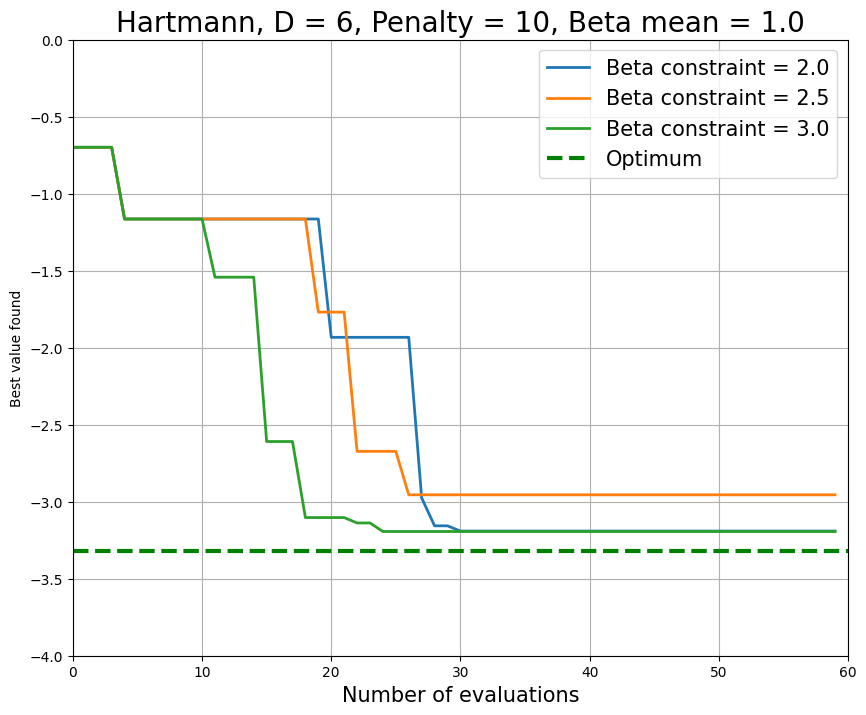

In [ ]:
%matplotlib inline
#average values from the different trials first
Y_all_avg = Y_all.mean(dim = 0)

#give each penalty its own plot
#each plot will have all combinations of betas

for i, p in enumerate(penalty_list):
    for j, beta_mean in enumerate(beta_mean_list):
      fig, ax = plt.subplots(figsize=(10, 8))
      for k, beta_constraint in enumerate(beta_constraint_list):

        Y_KKT_np = negate_list * Y_all_avg[i, j, k].cpu().numpy()

        if negate_list < 0:
          ax.plot(np.minimum.accumulate(Y_KKT_np), lw = 2, label=f"Beta constraint = {beta_constraint}")
        elif negate_list > 0:
          ax.plot(np.maximum.accumulate(Y_KKT_np), lw = 2, label=f"Beta constraint = {beta_constraint}")

        ax.grid(True)
        ax.set_title(f"{name_list}, D = {dim_list}, Penalty = {p}, Beta mean = {beta_mean}", fontsize=20)
        ax.set_xlabel("Number of evaluations", fontsize=15)
        ax.set_xlim([0, len(Y_KKT_np)])
        ax.set_ylabel("Best value found", fontsize=10)
        ax.set_ylim([plot_bounds[0], plot_bounds[1]])
      ax.plot([0, len(Y_KKT_np)], [objective_list, objective_list], "--", c="g", lw=3, label="Optimum")
      ax.legend(fontsize=15, loc = "upper right")
    plt.show()